In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertTokenizerFast, BertModel, BertConfig

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from text_processing import fix_string

[nltk_data] Downloading package wordnet to /home/magnus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
np.random.seed(1234)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 1. Ленивый способ
Я возьму предобученый трансформер из **transformers** (буду использовать rubert-tiny) и дообучу его для задачи классификации. Буду использовать основные метрики классификации

In [3]:
df = pd.read_csv('data/train.csv')
new_df = df.copy()
new_df["text"] = df["text"].map(fix_string)

word_count = new_df["text"].apply(lambda x: len(x.split()))
word_count.max(), word_count.min(), word_count.mean(), word_count.std()

(299, 0, 9.274346984843598, 7.5761680790143)

In [4]:
df[word_count == 0]

,text,label
2241,так? -*- *- *-** - ** * -- *- *- *-**,1
4687,"надо, мне все надо и чем больше тем лучше:)",1
6969,- - - - - - - - - - - - - - - - - - - - - - - ...,1
9176,не что за - а - за что? ),1
11389,"если было бы так, здесь бы не было их",1


Стоит ограничить сообщения 64 словами, в дальнейшем для обработки длинных сообщений можно будет разделить сообщение по 64 слова, и сложить результаты модели на каждой из частей для предсказания класса

In [5]:
new_df = new_df[(word_count > 0) & (word_count <= 64)]
len(new_df) - len(df)

-33

In [6]:
X = np.array(new_df["text"])
Y = np.array(new_df["label"])

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.05, stratify=Y, shuffle=True
)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.1, stratify=y_train, shuffle=True
)

len(x_train), len(x_valid), len(x_test)

(10576, 1176, 619)

In [7]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny", num_labels=2
).to(device).train()

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [8]:
batch_size = 16
epochs = 10
weight_path_bert = "best_bert.pt"

In [9]:
from engine import BertDataset, bert_train_epoch, bert_eval_epoch

train_data = BertDataset(x_train, y_train, tokenizer)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data = BertDataset(x_valid, y_valid, tokenizer)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

test_data = BertDataset(x_test, y_test, tokenizer)
test_loader = DataLoader(test_data, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
loss_function = torch.nn.CrossEntropyLoss()

/home/magnus/Documents/Testovoe_sber/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
model.best_acc = 0
model.tokenizer = tokenizer

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model = model.train()
    correct_predictions, train_loss = bert_train_epoch(model, optimizer, train_loader, loss_function, device)
    print(f'Train loss {train_loss} accuracy {correct_predictions / len(train_data)}')

    model = model.eval()
    correct_predictions, val_loss = bert_eval_epoch(model, valid_loader, loss_function, device)
    current_acc = correct_predictions / len(valid_data)
    print(f'Val loss {val_loss} accuracy {current_acc}')

    if current_acc > model.best_acc:
        model.best_acc = current_acc
        torch.save(model, weight_path_bert)

    print('-' * 10)

print(model.best_acc)

Epoch 1/10
Train loss 0.5597811366534269 accuracy 0.7113274931907654
Val loss 0.4888742936624063 accuracy 0.7627550959587097
----------
Epoch 2/10
Train loss 0.464029548478379 accuracy 0.7853630781173706
Val loss 0.4706031502904119 accuracy 0.7644557952880859
----------
Epoch 3/10
Train loss 0.40619960526475024 accuracy 0.8189296126365662
Val loss 0.4835069336601206 accuracy 0.7704081535339355
----------
Epoch 4/10
Train loss 0.3595798329285342 accuracy 0.8438917994499207
Val loss 0.4942210210940322 accuracy 0.7687074542045593
----------
Epoch 5/10
Train loss 0.3211335728054869 accuracy 0.8653554916381836
Val loss 0.5039865545727111 accuracy 0.7823129296302795
----------
Epoch 6/10
Train loss 0.2854191019015215 accuracy 0.8829424977302551
Val loss 0.5348457547055708 accuracy 0.7763605117797852
----------
Epoch 7/10
Train loss 0.24640654272057466 accuracy 0.902609646320343
Val loss 0.5790631580795791 accuracy 0.7687074542045593
----------
Epoch 8/10
Train loss 0.21839067412881286 accura

In [11]:
model = torch.load(weight_path_bert).to(device).eval()

classes = ["Чат по Python", "Чат по DS"]

def get_bad_prediction(model, data):
    predict, target = [], []
    bad_prediction = []

    with torch.no_grad():
        for i in data:
            input_ids = i["input_ids"].to(device).unsqueeze(0)
            attention_mask = i["attention_mask"].to(device).unsqueeze(0)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )["logits"]

            predict.append(bool(outputs.argmax()))
            target.append(bool(i["targets"]))

            if outputs.argmax() != i["targets"]:
                bad_prediction.append([i['text'], classes[i["targets"].item()]])
    return predict, target, sorted(bad_prediction, key=lambda x: x[0], reverse=True)

def print_score(predict, target):
    print(
        f"accuracy = {accuracy_score(predict, target)}\nprecision = {precision_score(predict, target)}\
        \nrecall = {recall_score(predict, target)}\nf1 = {f1_score(predict, target)}"
    )

Точность модели:

In [12]:
for name, data in zip(["train", "val", "test"], [train_data, valid_data, test_data]):
    predict, target, bad_pred = get_bad_prediction(model, data)

    print(f"Результаты на {name}:")
    print_score(predict, target)
    print("худшие примеры:")
    for i in bad_pred[:3]:
        print(i)

    print("-" * 10)

Результаты на train:
accuracy = 0.9120650529500757
precision = 0.9538409129620167        
recall = 0.8947116152740054
f1 = 0.9233305853256388
худшие примеры:
['ясн друг множествен запрос rest api котор ddos ит куч параллельн запрос прокс', 'Чат по DS']
['ясл соря', 'Чат по Python']
['язык общ пользован имеет вид написа фронтенд бэкенд например', 'Чат по DS']
----------
Результаты на val:
accuracy = 0.782312925170068
precision = 0.8453292496171516        
recall = 0.7807637906647807
f1 = 0.8117647058823528
худшие примеры:
['ютуб гайд написа бот', 'Чат по Python']
['юзер звонк инет привязк дат расшифровк происход то зон юзер', 'Чат по DS']
['юза вмест rethinkdb дан хран json', 'Чат по Python']
----------
Результаты на test:
accuracy = 0.7625201938610663
precision = 0.8168604651162791        
recall = 0.7698630136986301
f1 = 0.7926657263751763
худшие примеры:
['эт фигн хоч сраз валидац ответ', 'Чат по Python']
['эт тип лог так принят класт реляцион', 'Чат по Python']
['эт стол сложн задач

### Выводы
Bert оказалась слишком сложной моделью для этой задачи, скорее всего повлияло плохое распределение датасета (неравномерная длина сообщения в трэйне и тесте, более редкие слова встречались чаще в тесте, чем в трэйне) надо было написать или найти сэмплер для текста. Так же можно обучать с маскированием или шумными функциями для текста, так модель быстрее бы запомнила редкие слова и структуру сообщений в чате.

## 2. Доработать Берт
Возможно модель плохо обучилась, потому что в датасете очень много незнакомых слов, стоит переобучить токенайзер и соответсвенно эмбеддинг

In [13]:
vocab_size = 2 ** 14

# обучаю новый токенайзер
tokenizer = BertTokenizerFast.from_pretrained("cointegrated/rubert-tiny")
tokenizer = tokenizer.train_new_from_iterator(X, vocab_size)
model.tokenizer = tokenizer

# конфиг для модели донора
new_config = model.config
new_config.vocab_size = vocab_size

# изменяю ембединг
new_model = BertModel(new_config).to(device)
model.bert.embeddings = new_model.embeddings

model = model.train()

# замораживаю веса
model.requires_grad_(False)
model.bert.embeddings.requires_grad_(True)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

model.bert.embeddings.word_embeddings.weight.requires_grad, model.bert.encoder.layer[0].attention.self.query.weight.requires_grad

/home/magnus/Documents/Testovoe_sber/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


(True, False)

In [14]:
train_data = BertDataset(x_train, y_train, model.tokenizer)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data = BertDataset(x_valid, y_valid, model.tokenizer)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

test_data = BertDataset(x_test, y_test, model.tokenizer)
test_loader = DataLoader(test_data, batch_size=batch_size)

2 эпохи для обучения нового эмбединга

In [15]:
model.best_acc = 0
epochs = 2

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    # model = model.train()
    correct_predictions, train_loss = bert_train_epoch(model, optimizer, train_loader, loss_function, device)
    print(f'Train loss {train_loss} accuracy {correct_predictions / len(train_data)}')

    print('-' * 10)

print(model.best_acc)

Epoch 1/2
Train loss 0.6174467542348219 accuracy 0.6730332374572754
----------
Epoch 2/2
Train loss 0.42323020574004133 accuracy 0.8142964839935303
----------
0


Теперь полноценное обучение

In [16]:
weight_path_new_bert = "best_bert_new_tokenizer.pt"

model.requires_grad_(True)
model.bert.encoder.layer[0].attention.self.query.weight.requires_grad

True

In [17]:
model.best_acc = 0
model.tokenizer = tokenizer
epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model = model.train()
    correct_predictions, train_loss = bert_train_epoch(model, optimizer, train_loader, loss_function, device)
    print(f'Train loss {train_loss} accuracy {correct_predictions / len(train_data)}')

    model = model.eval()
    correct_predictions, val_loss = bert_eval_epoch(model, valid_loader, loss_function, device)
    current_acc = correct_predictions / len(valid_data)
    print(f'Val loss {val_loss} accuracy {current_acc}')

    if current_acc > model.best_acc:
        model.best_acc = current_acc
        torch.save(model, weight_path_new_bert)

    print('-' * 10)

print(model.best_acc)

Epoch 1/10
Train loss 0.34526755714312807 accuracy 0.8519288897514343
Val loss 0.47905171753184217 accuracy 0.7967686653137207
----------
Epoch 2/10
Train loss 0.2524181635354317 accuracy 0.9000567197799683
Val loss 0.5036064687411528 accuracy 0.7874149680137634
----------
Epoch 3/10
Train loss 0.20271579368651454 accuracy 0.9200075268745422
Val loss 0.5400593685539993 accuracy 0.7908163070678711
----------
Epoch 4/10
Train loss 0.162114782336361 accuracy 0.9397692680358887
Val loss 0.5807000078462266 accuracy 0.7908163070678711
----------
Epoch 5/10
Train loss 0.12956458012433933 accuracy 0.9506429433822632
Val loss 0.637724176149916 accuracy 0.7942176461219788
----------
Epoch 6/10
Train loss 0.10219696921376728 accuracy 0.9617056846618652
Val loss 0.7278462199594926 accuracy 0.7908163070678711
----------
Epoch 7/10
Train loss 0.0849674245245394 accuracy 0.9697427749633789
Val loss 0.772433947469737 accuracy 0.784013569355011
----------
Epoch 8/10
Train loss 0.0696925594754596 accura

In [18]:
model = torch.load(weight_path_new_bert).to(device)

for name, data in zip(["train", "val", "test"], [train_data, valid_data, test_data]):
    predict, target, bad_pred = get_bad_prediction(model, data)

    print(f"Результаты на {name}:")
    print_score(predict, target)
    print("худшие примеры:")
    for i in bad_pred[:3]:
        print(i)

    print("-" * 10)

Результаты на train:
accuracy = 0.9244515885022693
precision = 0.9460057911769716        
recall = 0.9201457919151756
f1 = 0.932896615436298
худшие примеры:
['ясн друг множествен запрос rest api котор ddos ит куч параллельн запрос прокс', 'Чат по DS']
['язык общ пользован имеет вид написа фронтенд бэкенд например', 'Чат по DS']
['эт эт одн', 'Чат по Python']
----------
Результаты на val:
accuracy = 0.7967687074829932
precision = 0.8529862174578867        
recall = 0.7957142857142857
f1 = 0.8233555062823356
худшие примеры:
['ээээ маленьк так слов слыша чита пойд гугл всем спасиб', 'Чат по DS']
['эффект начина работа ощутим значен крошечн', 'Чат по DS']
['эт чита смысл', 'Чат по Python']
----------
Результаты на test:
accuracy = 0.7964458804523424
precision = 0.8313953488372093        
recall = 0.807909604519774
f1 = 0.8194842406876792
худшие примеры:
['юзер аутист умеет оптимизирова', 'Чат по Python']
['ээээ регион чувак писа сюд стнегион проблем реша саппорт', 'Чат по DS']
['эт так про

### Выводы
Результат оказался лучше, но не таким как я ожидал, думаю с сэмплером и некоторыми селф-супервайз подходами результат мог быть лучше.

## 3. Лёгкая модель
Стоит попробовать сделать лёгкую модель, потому что предыдущие решения могут быть излишни

Нужно построить токенайзер

In [19]:
from torchtext.vocab import build_vocab_from_iterator
from engine import SimpleDataset, SimpleClassificator, simple_train_epoch, simple_eval_epoch

import matplotlib.pyplot as plt

In [20]:
def yield_tokens():
    for i in new_df["text"]:
        yield i.split()

vocab = build_vocab_from_iterator(yield_tokens(), specials=["_"])  # specials for padding

In [21]:
batch_size = 128
max_tokens = 64

In [22]:
train_data = SimpleDataset(x_train, y_train, vocab, max_tokens)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data = SimpleDataset(x_valid, y_valid, vocab, max_tokens)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

test_data = SimpleDataset(x_test, y_test, vocab, max_tokens)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [23]:
model = SimpleClassificator(len(vocab), max_tokens).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_function = nn.CrossEntropyLoss()

In [24]:
epochs = 500
model.best_acc = 0
model.vocab = vocab

simple_weight_path = "best_simple.pt"

train_history = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model = model.train()
    correct_predictions, train_loss = simple_train_epoch(model, optimizer, train_loader, loss_function, device)
    train_acc = correct_predictions / len(train_data)
    train_acc = train_acc.item()
    print(f'Train loss {train_loss} accuracy {train_acc}')

    model = model.eval()
    correct_predictions, val_loss = simple_eval_epoch(model, valid_loader, loss_function, device)
    current_acc = correct_predictions / len(valid_data)
    current_acc = current_acc.item()
    print(f'Val loss {val_loss} accuracy {current_acc}')

    train_history.append([train_loss, val_loss, train_acc, current_acc])

    if current_acc > model.best_acc:
        model.best_acc = current_acc
        torch.save(model, simple_weight_path)

    print('-' * 10)

Epoch 1/500
Train loss 0.6903196163924343 accuracy 0.5387669801712036
Val loss 0.6864371836185456 accuracy 0.555272102355957
----------
Epoch 2/500
Train loss 0.6862077217504202 accuracy 0.5566376447677612
Val loss 0.6859510004520416 accuracy 0.5612244606018066
----------
Epoch 3/500
Train loss 0.6826295342790075 accuracy 0.5678895115852356
Val loss 0.6878229081630707 accuracy 0.5612244606018066
----------
Epoch 4/500
Train loss 0.6754190239561609 accuracy 0.5816943645477295
Val loss 0.6839608490467072 accuracy 0.5705782175064087
----------
Epoch 5/500
Train loss 0.6660277225885046 accuracy 0.5941754579544067
Val loss 0.6746254742145539 accuracy 0.5807822942733765
----------
Epoch 6/500
Train loss 0.6514588163559696 accuracy 0.6078857779502869
Val loss 0.6674558401107789 accuracy 0.6113945245742798
----------
Epoch 7/500
Train loss 0.6367719115981136 accuracy 0.6193267703056335
Val loss 0.6618392765522003 accuracy 0.6139455437660217
----------
Epoch 8/500
Train loss 0.6188933325101094 

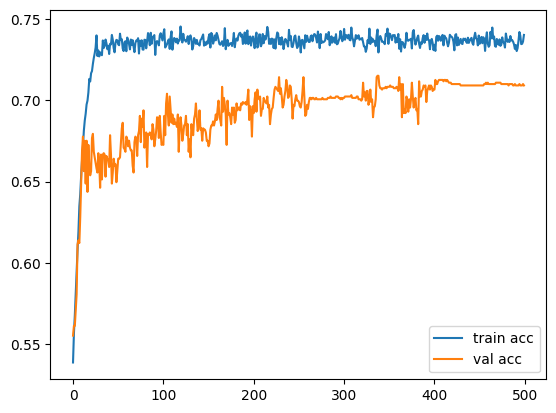

In [25]:
train_history = np.array(train_history)
plt.plot(train_history[:, 2], label="train acc")
plt.plot(train_history[:, 3], label="val acc")
plt.legend()
plt.show()

### Выводы
Модель слишком лёгкая для такой задачи, зато быстрая

## 4. Попробовать стандартный пайплайн TF-IDF + Логистическая регрессия

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [27]:
tfidf = TfidfVectorizer()
out = tfidf.fit_transform(np.array(new_df["text"]))

20 самых частых и самых редких слов

In [28]:
sort_idx = np.ravel(out.sum(axis=0).argsort(axis=1))[::-1]
np.array(tfidf.get_feature_names_out())[sort_idx][:20], np.array(tfidf.get_feature_names_out())[sort_idx][-20:]

(array(['эт', 'прост', 'так', 'котор', 'дела', 'нужн', 'работа', 'дан',
        'одн', 'сдела', 'вообщ', 'сам', 'дума', 'говор', 'теб', 'код',
        'как', 'друг', 'питон', 'вопрос'], dtype=object),
 array(['00907', 'right', 'excelsheet', 'verbos', 'projectnumb', 'lost',
        'prefix', 'volatil', 'reboot', 'persist', 'sinc', 'suffici',
        'mkdir', 'nbi', 'tmpfile', 'python37', 'блджад', 'dynload',
        'bearer', 'nпод'], dtype=object))

In [29]:
x_train_tf = tfidf.transform(x_train)
x_test_tf = tfidf.transform(x_test)
x_valid_tf = tfidf.transform(x_valid)

In [30]:
model = LogisticRegression(random_state=42, n_jobs=-1)

params = {
    'C': np.arange(0.5, 2.6, 0.25)
}

grid_search = GridSearchCV(
    model, params, n_jobs=-1, cv=3
)

grid_search.fit(x_train_tf, y_train)

grid_search.best_params_, grid_search.best_score_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

({'C': 2.0}, 0.7762858548921957)

In [31]:
model = LogisticRegression(random_state=42, n_jobs=-1, C=2).fit(x_train_tf, y_train)

In [32]:
for name, data, target in zip(["train", "val", "test"], [x_train_tf, x_test_tf, x_valid_tf], [y_train, y_test, y_valid]):
    predict = model.predict(data)

    print(f"Результаты на {name}:")
    print_score(predict, target)

    print("-" * 10)

Результаты на train:
accuracy = 0.9215204236006052
precision = 0.9536705842275592        
recall = 0.9093714471333442
f1 = 0.9309943465247755
----------
Результаты на val:
accuracy = 0.8061389337641357
precision = 0.877906976744186        
recall = 0.7947368421052632
f1 = 0.8342541436464088
----------
Результаты на test:
accuracy = 0.7967687074829932
precision = 0.886676875957121        
recall = 0.7782258064516129
f1 = 0.8289191123836793
----------


In [34]:
import pickle

In [35]:
pickle.dump(tfidf, open('tfidf.pickle', 'wb'))
pickle.dump(model, open('logreg.pickle', 'wb'))

## Итог
Лучше всего себя показал модель на TF-IDF, и по скорости и по качеству. Есть ощущение, что из трансформеров можно выжать сильно больше.
